# Analysis of ACS Public Use Microdata Sample

In [1]:
import pandas as pd
import sqlite3 as sq
import matplotlib.pyplot as plt
import numpy as np
import seaborn
%matplotlib inline

Read in the data from the 2 csv files. File 'a' contains data from the first 25 states, and file b from the last 25 states. Each files is about 1.5 GB.

There are 283 columns of data, but we're only going to read in a subset of the columns. The data dictionary can be found at http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt .

After we read in each dataframe, we can concatenate them into a single dataframe.

In [11]:
use_cols = ['SERIALNO','PUMA','ST','ADJINC','PWGTP','AGEP','CIT','CITWP',
            'COW','DDRS','DEAR','DEYE','ENG','HINS1','HINS2','HINS3',
            'HINS4','HINS5','HINS6','HINS7','INTP','JWMNP','JWRIP','JWTR',
            'MAR','MIG','OIP','PAP','RETP','SCHL','SEMP','SEX','SSIP','SSP',
            'WAGP','WKHP','WKL','WKW','YOEP','DIS','ESR','FOD1P','HICOV', 
            'INDP','JWAP','JWDP','NATIVITY','NOP','OCCP','PERNP','PINCP',
            'RAC1P','SCIENGP','SCIENGRLP','WAOB']
PUMS_a = pd.read_csv('ss13pusa.csv', usecols = use_cols)
PUMS_b = pd.read_csv('ss13pusb.csv', usecols = use_cols)

In [18]:
PUMS_full = pd.concat([PUMS_a,PUMS_b])

In [19]:
PUMS_full.shape

(3132795, 55)

We now have a single dataframe with 55 columns and about 3 million rows. It's easier to work with pandas to clean data, but this data is already in a very useable format.

It'll be easier to work with the data if it's in a SQLite database. We can do this using the pandas function to_sql.

In [20]:
conn = sq.connect('PUMS.db')
PUMS_full.to_sql('PUMS',conn,index = False)

We can quickly check the table info for our new table using pragma table_info():

In [23]:
table_info = conn.execute('pragma table_info(PUMS);').fetchall()
for info in table_info: print(info)

(0, u'SERIALNO', u'INTEGER', 0, None, 0)
(1, u'PUMA', u'INTEGER', 0, None, 0)
(2, u'ST', u'INTEGER', 0, None, 0)
(3, u'ADJINC', u'INTEGER', 0, None, 0)
(4, u'PWGTP', u'INTEGER', 0, None, 0)
(5, u'AGEP', u'INTEGER', 0, None, 0)
(6, u'CIT', u'INTEGER', 0, None, 0)
(7, u'CITWP', u'REAL', 0, None, 0)
(8, u'COW', u'REAL', 0, None, 0)
(9, u'DDRS', u'REAL', 0, None, 0)
(10, u'DEAR', u'INTEGER', 0, None, 0)
(11, u'DEYE', u'INTEGER', 0, None, 0)
(12, u'ENG', u'REAL', 0, None, 0)
(13, u'HINS1', u'INTEGER', 0, None, 0)
(14, u'HINS2', u'INTEGER', 0, None, 0)
(15, u'HINS3', u'INTEGER', 0, None, 0)
(16, u'HINS4', u'INTEGER', 0, None, 0)
(17, u'HINS5', u'INTEGER', 0, None, 0)
(18, u'HINS6', u'INTEGER', 0, None, 0)
(19, u'HINS7', u'INTEGER', 0, None, 0)
(20, u'INTP', u'REAL', 0, None, 0)
(21, u'JWMNP', u'REAL', 0, None, 0)
(22, u'JWRIP', u'REAL', 0, None, 0)
(23, u'JWTR', u'REAL', 0, None, 0)
(24, u'MAR', u'INTEGER', 0, None, 0)
(25, u'MIG', u'REAL', 0, None, 0)
(26, u'OIP', u'REAL', 0, None, 0)
(27, 

In [58]:
del PUMS_a, PUMS_b

Now we're ready to start doing some analysis. Let's start with something really basic: looking at the male / female breakdown of the persons included in the study. The only response options here are '1': Male and '2': Female.

In [50]:
query = ('SELECT count(SEX) FROM PUMS WHERE SEX == 1 '
         'UNION '
         'SELECT count(SEX) FROM PUMS WHERE SEX == 2 '
         'UNION '
         'SELECT count(*) FROM PUMS;')
        

output = conn.execute(query).fetchall()
n_males = output[0][0]
n_females = output[1][0]
n_tot = output[2][0]

print('Total number of males is %i; %.2f percent of total' %(n_males, 100.00*n_males/n_tot))
print('Total number of females is %i; %.2f percent of total' %(n_females, 100.00*n_females/n_tot))


Total number of males is 1528734; 48.80 percent of total
Total number of females is 1604061; 51.20 percent of total


Now let's look at the distribution of earnings by sex. 
The column 'PERNP' contains the dollar amount of total earnings in the past 12 months. 
The column 'ADJINC' is the adjustment factor to inflation-adjust reported income to 2013 dollars.

In [60]:
query = ('SELECT PERNP*ADJINC FROM PUMS WHERE SEX==1 '
         'UNION '
         'SELECT PERNP*ADJINC FROM PUMS WHERE SEX==2;')
output = conn.execute(query).fetchall()
male_earnings = np.asarray(output[0])
female_earnings = np.asarray(output[1])

In [61]:
type(male_earnings)

numpy.ndarray

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

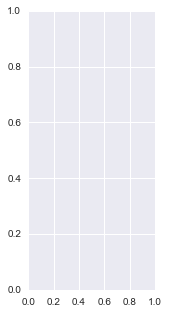

In [62]:
plt.figure(figsize = (5,5))
plt.subplot(1,2,1)
seaborn.distplot(male_earnings)
plt.subplot(1,2,2)
seaborn.displot(female_earnings)
plt.show()